# Deep CNN for computer vision

Contest link:

https://contest.yandex.ru/contest/68196/enter

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

from math import ceil, sqrt

import numpy as np
import random

# autoreload ALL modules in real time
%load_ext autoreload
%autoreload 2

In [ ]:
# Section of setting seeds for reproducible results of training CNNs

# Set the seed for the Python random module
random.seed(0)

# Set the seed for NumPy's random number generator
np.random.seed(1)

# Set the seed for PyTorch's random number generator
torch.manual_seed(2)

# If training on GPU, set the seed for the GPU backend and CUDA library
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3)

g = torch.Generator()
g.manual_seed(4)

In [ ]:
def show_images(images, labels=None, title=None, transform=None, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize, linewidth=5)
    grid_val = ceil(sqrt(len(images)))
    grid_specs = plt.GridSpec(grid_val, grid_val)

    for i, image in enumerate(images):
        ax = fig.add_subplot(grid_specs[i // grid_val, i % grid_val])
        ax.axis('off')

        if transform is not None:
            image = transform(image)

        if labels is not None:
            ax_title = labels[i]
        else:
            ax_title = '#{}'.format(i+1)

        ax.set_title(ax_title)
        ax.imshow(image, cmap='gray')

    if title:
        fig.suptitle(title, y=0.93, fontsize='xx-large')
    plt.show()


In [ ]:
# Your imports

num_workers = 4     # maximum number of subprocces (check https://pytorch.org/docs/stable/data.html for more info)
batch_size = 1024


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda device


# Task #1: Basic Pipeline [4 points]

## Step 1: Data Preparation

### Load [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) from torchvision.datasets

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# download data
train_data = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


### Create dataloaders and plot some examples

In [ ]:
# create dataloaders for model
train_dataloader = torch.utils.data.DataLoader(
    train_data, shuffle=True,
    batch_size=batch_size, num_workers=num_workers, generator=g
)

test_dataloader = torch.utils.data.DataLoader(
    test_data, shuffle=True,
    batch_size=batch_size, num_workers=num_workers, generator=g
)

# show some images from CIFAR
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}

N_samples = 16
images, labels = next(iter(train_dataloader))
# show_images(
#     images[:N_samples],
#     [labels_map[i.item()] for i in labels[:N_samples]],
#     transform=transforms.ToPILImage()
# )


**Hint!**

Use can use ```torchvision.utils.make_grid()``` for your own plots. Check [documentation](https://pytorch.org/vision/stable/utils.html) for examples.


## Step 2: Neural Network training

In this task, you will fill in the gaps in a typical Pytorch neural network training pipeline.

For clarity (and subsequent comparison with Deep CNN networks), we will use the simplest perceptron as a model.

**Hint!** You can change the size and number of hidden layers by passing a list of them as an argument to ```blocks```.

### Neural Network Architecrute

In [ ]:
from collections import OrderedDict

class MLP(nn.Module):
    """
        Simple linear network — multi-layer perceptron
    """
    def __init__(self, input_size, num_layers, hidden_sizes, output_size, activations, dropouts):
        super(MLP, self).__init__()

        if not isinstance(hidden_sizes, list):
            hidden_sizes = [hidden_sizes] * num_layers
        assert len(hidden_sizes) == num_layers, f'provide {num_layers} hidden_sizes or just one for all layers'

        if not isinstance(activations, list):
            activations = [activations] * num_layers
        assert len(activations) == num_layers, f'provide {num_layers} activation functions or just one for all layers'

        if not isinstance(dropouts, list):
            dropouts = [dropouts] * num_layers
        assert len(dropouts) == num_layers, f'provide {num_layers} dropout values or just one for all layers'

        flat = ('flat', nn.Flatten())
        in_to_hid = ('in2hid', nn.Linear(input_size, hidden_sizes[0]))

        hid_ = [[
            (f'act_{i+1}', activations[i]),
            (f'drop_{i+1}', nn.Dropout(dropouts[i])),
            (f'hid_{i+1}', nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        ] for i in range(num_layers-1)]

        hid = []
        for el in hid_:
            hid.extend(el)

        head = [
            (f'act_{num_layers}', activations[-1]),
            (f'drop_{num_layers}', nn.Dropout(dropouts[-1])),
            ('hid2out', nn.Linear(hidden_sizes[-1], output_size)),
            ('log-softmax', nn.LogSoftmax(dim=-1))
        ]

        self.net = [flat, in_to_hid, *hid, *head]
        self.net = nn.Sequential(OrderedDict(self.net))

    def forward(self, imgs):
        return self.net(imgs)


**Hint!** You can refer to the [pytorch documentation](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) for examples of implementing the ```train_loop()``` and ```test_loop()``` functions.

### Train-test loops

In [ ]:
import IPython
from math import ceil


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    train_acc, train_loss = [], []
    percentage = 0

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # evaluate
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        train_acc.append(correct / len(X))
        train_loss.append(loss.item())

        # print info
        if batch / batches > percentage or batch == batches:
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step

    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    val_loss, val_acc = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # evaluate
            pred = model(X)
            loss = loss_fn(pred, y)

            # accumulate loss and accuracy
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            val_loss.append(loss.item())
            val_acc.append((pred.argmax(1) == y).type(torch.float).mean().item())

    test_loss /= batches
    correct /= size

    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))

    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}


### Learning curves

Plot ```loss_fn``` and ```accuracy``` for the training and test sets against the training epoch.

**Hint!** Don't skip this point: other tasks may require appropriate schedules.

In [ ]:
def plot_learning_process(train_loss, train_acc, val_loss, val_acc):

    fig = plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(121)
    ax1.set_title('loss by epoch')
    ax1.plot(np.arange(0, len(train_loss)) + 0.5, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss function')

    ax2 = plt.subplot(122)
    ax2.set_title('accuracy by epoch')
    ax2.plot(np.arange(0, len(train_acc)) + 0.5, train_acc, label='train')
    ax2.plot(np.arange(0, len(val_acc)) + 1, val_acc, label='val')
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')

    fig.tight_layout()
    plt.show()

## Step 3: Train Network

What loss function should be used?

<details>
  <summary>When you're ready, click here to see the answer.</summary>
    <ol>
      <li>Negative log likelihood loss (NLLloss) should be used as a loss function</li>
      <li>Why don't we use CrossEntropyLoss?</li>
    </ol>
</details>

Also you should use Adam optimizer with default parameters.


In [ ]:
net = MLP(np.prod(images[0].shape), num_layers=5, hidden_sizes=[256, 512, 256, 128, 64], output_size=len(labels_map),
          activations=nn.ReLU(), dropouts=0.,).to(device)

# loss_fn, optimizer and number of epochs are required
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(net.parameters())
epochs = 30

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
# <----- your code here ----->
        # Тренировочный цикл
    train_metrics = train_loop(
        model=net,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        history_loss=train_loss,
        history_acc=train_acc
    )

    # Тестовый цикл
    val_metrics = test_loop(
        model=net,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        history_loss=val_loss,
        history_acc=val_acc
    )

    # Вывод результатов за эпоху
    print(f"Train Loss: {train_metrics['train_loss']:.4f}, Train Accuracy: {train_metrics['train_acc']:.4f}")
    print(f"Val Loss: {val_metrics['val_loss']:.4f}, Val Accuracy: {val_metrics['val_acc']:.4f}")


1. **(4 points)** Enter the values of the loss function and accuracy on the test dataset, obtained after 30 epochs of training the MLP model with the Adam optimizer. Round the values to one decimal place.

# Task #2: ResNet [4 points]

In this task, you will be required to fill in the gaps in the code below so that the resulting architecture matches ```resnet18```. We will use this particular architecture modification because of its small size and relative ease of self-implementation.

**Hint 0!**
As an example, you can rely on the corresponding implementation of ```resnet18``` from **pytorch**.

**Hint 1!**
First of all, try to match the described classes with the description of the model built into pytorch. Don't forget about sequential debugging.

In [ ]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
     '''
       This class should be implemented similarly to the BasicBlock from the pytorch implementation.

       Since in resnet18 all blocks have only two parameters that are responsible for the number of channels,
       we will also use a simplified notation.

       The first convolutional layer has the dimension (in_channels, out_channels),
       the second convolutional layer has the dimension (out_channels, out_channels).

       You are required to implement the correct forward() and __init__() methods for this block.

       Remember to use batch normalizations and activation functions.
       Shorcut will require you to understand what projection convolution is.

       In general, it is recommended to refer to the original article, the pytorch implementation and
       other sources of information to successfully assemble this block.

       Hint! You can use nn.Identity() to implement shorcut.
     '''

     def __init__(self, in_channels, out_channels):
         '''
         The block must have the following fields:
             *self.shorcut
             *self.activation
             *self.conv1
             *self.conv2
             *self.bn1
             *self.bn2

         Hint! Don't forget the bias, padding, and stride parameters for convolutional layers.
         '''

         super().__init__()
         stride = (2, 2) if in_channels != out_channels else (1, 1)

         # <----- your code here ----->


     def forward(self, x):
         '''
         '''

         residual = self.shortcut(x)

         # <----- your code here ----->

         return x + residual


class ResNetLayer(nn.Module):
     '''
     This class should be implemented similarly to layer from the pytorch implementation.

     To implement the layer, you will need to create two ResidualBlocks inside.
     Determining the appropriate dimensions is up to you.
     '''

     def __init__(self, in_channels, out_channels):
         '''
         The layer must have the following field declared:
             *self.blocks
         '''

         super().__init__()

         # <----- your code here ----->

     def forward(self, x):
         '''
         Note that blocks must be packed to make forward work in its original form.
         '''
         x = self.blocks(x)
         return x


class ResNet18(nn.Module):
     '''
     Finally, this class should consist of three main components:
       1. Four preparatory layers
       2. A set of internal ResNetLayers
       3. Final classifier

     Hint! In order for the network to process images from CIFAR10, you should replace the parameters
           of the first convolutional layer on kernel_size=(3, 3), stride=(1, 1) and padding=(1, 1).
     '''

     def __init__(self, in_channels=3, n_classes=10):
         '''
         The class must have the following fields declared:
             *self.conv1
             *self.bn1
             *self.activation
             *self.maxpool
             *self.layers
             *self.avgpool
             *self.flatten
             *self.fc

         A different grouping of parameters is allowed that does not violate the idea of the network architecture.
         '''

         super().__init__()

         # <----- your code here ----->

     def forward(self, x):

         # <----- your code here ----->

         return x


In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        stride = 2 if in_channels != out_channels else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU(inplace=True)


        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = self.activation(x)
        return x + residual


class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.blocks(x)


class ResNet18(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU(inplace=True)

        self.layer1 = ResNetLayer(64, 64)
        self.layer2 = ResNetLayer(64, 128)
        self.layer3 = ResNetLayer(128, 256)
        self.layer4 = ResNetLayer(256, 512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [ ]:
torchvision.models.resnet18() # uncomment this to see a Hint 0!

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Hint 3!**
Note the structure of ```resnet18```. The first part (before the appearance of ```(layer1): Sequential```) is the downsampling block. Don't forget to modify the network structure so that it applies to images from **CIFAR10**.

In [ ]:
dummy = ResNet18()(images) # this line should not throw an error

Train your model for a small number of epochs (6-30).

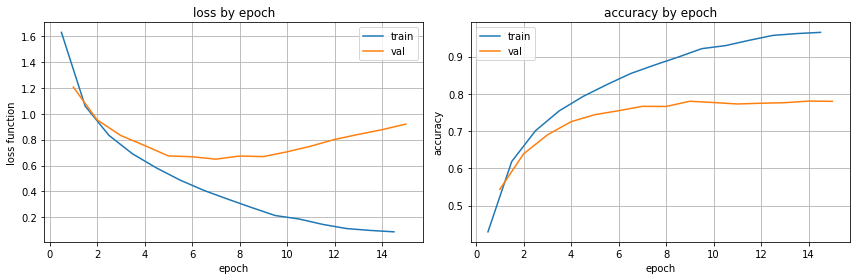

In [ ]:
# loss_fn, optimizer and number of epochs are required
# <----- your code here ----->

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # <----- your code here ----->


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model, loss function, optimizer, and number of epochs
model = ResidualBlock()  # Replace with your model definition
loss_fn = nn.CrossEntropyLoss()  # Example loss function, replace with the appropriate one
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Example optimizer, replace as needed
epochs = 10  # Set the number of epochs

# Define lists to store loss and accuracy values for plotting
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for inputs, targets in train_dataloader:  # Using train_dataloader here
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)  # Replace with your model's forward pass

        # Compute loss
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate the loss for logging
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate the training loss and accuracy
    train_loss.append(running_loss / len(train_dataloader))
    train_acc.append(correct / total)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradient computation during validation
        for inputs, targets in test_dataloader:  # Using test_dataloader here
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_running_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    # Calculate the validation loss and accuracy
    val_loss.append(val_running_loss / len(test_dataloader))
    val_acc.append(val_correct / val_total)

    # Print loss and accuracy for the epoch
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, "
          f"Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}")


plot_learning_process(train_loss, train_acc, val_loss, val_acc)

TypeError: ResidualBlock.__init__() missing 2 required positional arguments: 'in_channels' and 'out_channels'

Compare the learning process of a convolutional network Resnet18 and a Multi Layer Perceptron, as well as the number of parameters. What conclusions can be drawn?

<details>
  <summary>When you're ready, click here to see the answer.</summary>
    <li>ResNet18 and MLP are two different architectures designed for different types of data and learning tasks. ResNet18 is a powerful model for image classification tasks and has approximately 11M parameters, while MLP is a simpler model (1M parameters) only with fully-connected layers that can be used for a classification tasks.</li>
    <li>The choice of model depends on the specifics of the problem being solved, including the size and complexity of the data, the desired performance, and the available computing resources.</li>
    <li>Note that in fact, a convolutional network can show a significantly better result than MLP, even with a comparable number of parameters. As proof, you could «compress» ResNet18 using layers of width 6, 12, 24, 48 instead of the original 64, 128, 256, 512 and than check the performance.</li>
</details>

2. **(4 points)**. Upload the implementation of the `ResidualBlock`, `ResNetLayer`, and `ResNet18` classes to the Yandex Contest.

# Task #3: EfficientNet [4 points]

Sometimes there is no need to train models from scratch. Let's try to use a technique called **transfer learning** for this task. Unlike **fine tuning**, we will not retrain the entire network. Instead, we will use an already pre-trained network as a **fixed feature extractor**.

We will use the activations of the last convolutional layer as ready-made features. And already on these activations we will train our own classifier suitable for our task.

We will use the ```EfficientNet``` network trained on the **ImageNet** dataset.

To adapt it to our dataset, we need to **"freeze" the weights** and replace the model classifier.

**Hint!** See the [pytorch documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor) for details.

Please note that we are **not retraining the entire network**.

In [ ]:
from torchvision.models import efficientnet_b0


# load and freeze pretrained model
# <----- your code here ----->

# change classifier
# <----- your code here ----->


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchvision.models import efficientnet_b0
import torch.nn as nn

# Загрузка и замораживание предобученной модели
model = efficientnet_b0(pretrained=True)  # Загружаем предобученную модель на ImageNet
for param in model.parameters():
    param.requires_grad = False  # Замораживаем все параметры, чтобы использовать модель как feature extractor

# Замена классификатора
num_features = model.classifier[1].in_features  # Количество входных признаков старого классификатора
num_classes = 10  # Для CIFAR-10 у нас 10 классов

model.classifier = nn.Linear(num_features, num_classes)

In [ ]:
# <----- your code here ----->
batch_size = 512

transform_imagenet = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

# download data
train_data_imagenet = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform_imagenet
)

test_data_imagenet = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=transform_imagenet
)

train_dataloader_imagenet = torch.utils.data.DataLoader(
    train_data_imagenet, shuffle=False,
    batch_size=batch_size, num_workers=num_workers, generator=g
)

test_dataloader_imagenet = torch.utils.data.DataLoader(
    test_data_imagenet, shuffle=False,
    batch_size=batch_size, num_workers=num_workers, generator=g
)
# <----- your code here ----->


Files already downloaded and verified
Files already downloaded and verified


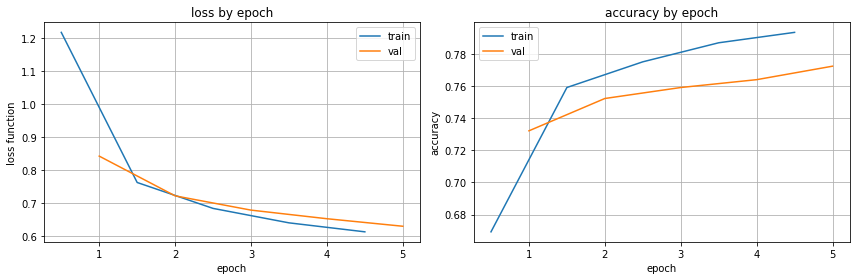

In [ ]:
# loss_fn, optimizer and number of epochs are required

optimized_params = []
for param in eff_net.parameters():
    if param.requires_grad:
        optimized_params.append(param)

loss_fn = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(optimized_params)
epochs = 5

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    # <----- your code here ----->


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# loss_fn, optimizer and number of epochs are required

optimized_params = []
for param in model.parameters():
    if param.requires_grad:
        optimized_params.append(param)

loss_fn = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(optimized_params)
epochs = 5

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_metrics = train_loop(
        model=model,  # Используем модель, определённую ранее
        dataloader=train_dataloader_imagenet,
        loss_fn=loss_fn,
        optimizer=optimizer,
        history_loss=train_loss,
        history_acc=train_acc
    )

    val_metrics = test_loop(
        model=model,  # Аналогично, используем ту же модель
        dataloader=test_dataloader_imagenet,
        loss_fn=loss_fn,
        history_loss=val_loss,
        history_acc=val_acc
    )

    print(f"Training Loss: {train_metrics['train_loss']:.4f}, "
          f"Training Accuracy: {train_metrics['train_acc']:.4f}")
    print(f"Validation Loss: {val_metrics['val_loss']:.4f}, "
          f"Validation Accuracy: {val_metrics['val_acc']:.4f}")

Epoch 1
-------------------------------


'[50000/50000] Loss: 0.870327'

Batch #:   0%|          | 0/98 [00:00<?, ?it/s]

Validation accuracy: 74.5%, Validation loss: 0.841904 

Training Loss: 1.2155, Training Accuracy: 0.6747
Validation Loss: 0.8419, Validation Accuracy: 0.7442
Epoch 2
-------------------------------


'[50000/50000] Loss: 0.741051'

Batch #:   0%|          | 0/98 [00:00<?, ?it/s]

Validation accuracy: 76.5%, Validation loss: 0.722363 

Training Loss: 0.7619, Training Accuracy: 0.7615
Validation Loss: 0.7224, Validation Accuracy: 0.7642
Epoch 3
-------------------------------


'[50000/50000] Loss: 0.659952'

Batch #:   0%|          | 0/98 [00:00<?, ?it/s]

Validation accuracy: 77.9%, Validation loss: 0.670514 

Training Loss: 0.6768, Training Accuracy: 0.7829
Validation Loss: 0.6705, Validation Accuracy: 0.7787
Epoch 4
-------------------------------


'[50000/50000] Loss: 0.652804'

Batch #:   0%|          | 0/98 [00:00<?, ?it/s]

Validation accuracy: 78.3%, Validation loss: 0.651302 

Training Loss: 0.6416, Training Accuracy: 0.7883
Validation Loss: 0.6513, Validation Accuracy: 0.7827
Epoch 5
-------------------------------


'[50000/50000] Loss: 0.594651'

Batch #:   0%|          | 0/98 [00:00<?, ?it/s]

Validation accuracy: 78.6%, Validation loss: 0.637782 

Training Loss: 0.6161, Training Accuracy: 0.7951
Validation Loss: 0.6378, Validation Accuracy: 0.7852


## Comparsion and tuning

Retrain four EfficientNet networks from the ```torchvision.models``` library using **transfer learning**: b0, b1, b2, b3, using epochs = 3, cross_entropy loss and Adam optimizer.

In [ ]:
models = {}
models['b0'] = torchvision.models.efficientnet_b0(pretrained=True)
models['b1'] = torchvision.models.efficientnet_b1(pretrained=True)
models['b2'] = torchvision.models.efficientnet_b2(pretrained=True)
models['b3'] = torchvision.models.efficientnet_b3(pretrained=True)

train_acc_comp, train_loss_comp, val_acc_comp, val_loss_comp = {}, {}, {}, {}
epochs = 3
batch_size = 512

# # <----- your code here ----->

#     for epoch in range(epochs):
#         print(f"Epoch {epoch+1}, model {model_type} \n-------------------------------")
#         train_loop(model, train_dataloader_imagenet, loss_fn, optimizer, history_loss=train_loss_comp[model_type], history_acc=train_acc_comp[model_type])
#         test_loop(model, test_dataloader_imagenet, loss_fn, history_loss=val_loss_comp[model_type], history_acc=val_acc_comp[model_type])
#         clear_output()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 158MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to g

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Словарь для хранения метрик
train_acc_comp, train_loss_comp, val_acc_comp, val_loss_comp = {}, {}, {}, {}

# Параметры обучения
epochs = 3
batch_size = 512
loss_fn = torch.nn.CrossEntropyLoss()

# Датасеты и преобразования
transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data_imagenet = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_imagenet
)
test_data_imagenet = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_imagenet
)

train_dataloader_imagenet = torch.utils.data.DataLoader(
    train_data_imagenet, shuffle=True, batch_size=batch_size
)
test_dataloader_imagenet = torch.utils.data.DataLoader(
    test_data_imagenet, shuffle=False, batch_size=batch_size
)

# Перебираем каждую модель EfficientNet
for model_type, base_model in models.items():
    print(f"Training model: {model_type}")

    # Подготовка модели
    model = base_model
    model = model.to(device)

    # Замораживаем веса и заменяем классификатор
    for param in model.parameters():
        param.requires_grad = False

    # Замена классификатора на дефолтный
    num_features = model.classifier.in_features  # Количество входных признаков у старого классификатора
    num_classes = 10  # CIFAR-10 содержит 10 классов

    # Новый классификатор с дефолтной архитектурой (без скрытых слоев)
    model.classifier = nn.Linear(num_features, num_classes).to(device)

    # Оптимизатор
    optimizer = torch.optim.Adam(model.classifier.parameters())

    # Инициализация словарей для хранения метрик
    train_acc_comp[model_type] = []
    train_loss_comp[model_type] = []
    val_acc_comp[model_type] = []
    val_loss_comp[model_type] = []

    # Цикл обучения
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}, model {model_type} \n-------------------------------")

        # Обучение
        train_loop(
            model=model,
            dataloader=train_dataloader_imagenet,
            loss_fn=loss_fn,
            optimizer=optimizer,
            history_loss=train_loss_comp[model_type],
            history_acc=train_acc_comp[model_type]
        )

        # Валидация
        test_loop(
            model=model,
            dataloader=test_dataloader_imagenet,
            loss_fn=loss_fn,
            history_loss=val_loss_comp[model_type],
            history_acc=val_acc_comp[model_type]
        )

        clear_output()

# Графики обучения для каждой модели
for model_type in models.keys():
    print(f"Model {model_type}")
    plot_learning_process(
        train_loss_comp[model_type],
        train_acc_comp[model_type],
        val_loss_comp[model_type],
        val_acc_comp[model_type]
    )


Files already downloaded and verified
Files already downloaded and verified
Training model: b0


AttributeError: 'Sequential' object has no attribute 'in_features'

In [ ]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=10, bias=True)
)


Plot the error and accuracy during training against the number of elapsed epochs for all networks.

**Hint 1!** All networks (as well as the legend) must be represented on one graph, but only one of the four parameters.

**Hint 1.5!** It follows from the previous paragraph that there should be... four graphs.

**Hint 2!** Take advantage of the ability to create ```subplot``` in the ```matplotlib``` library.

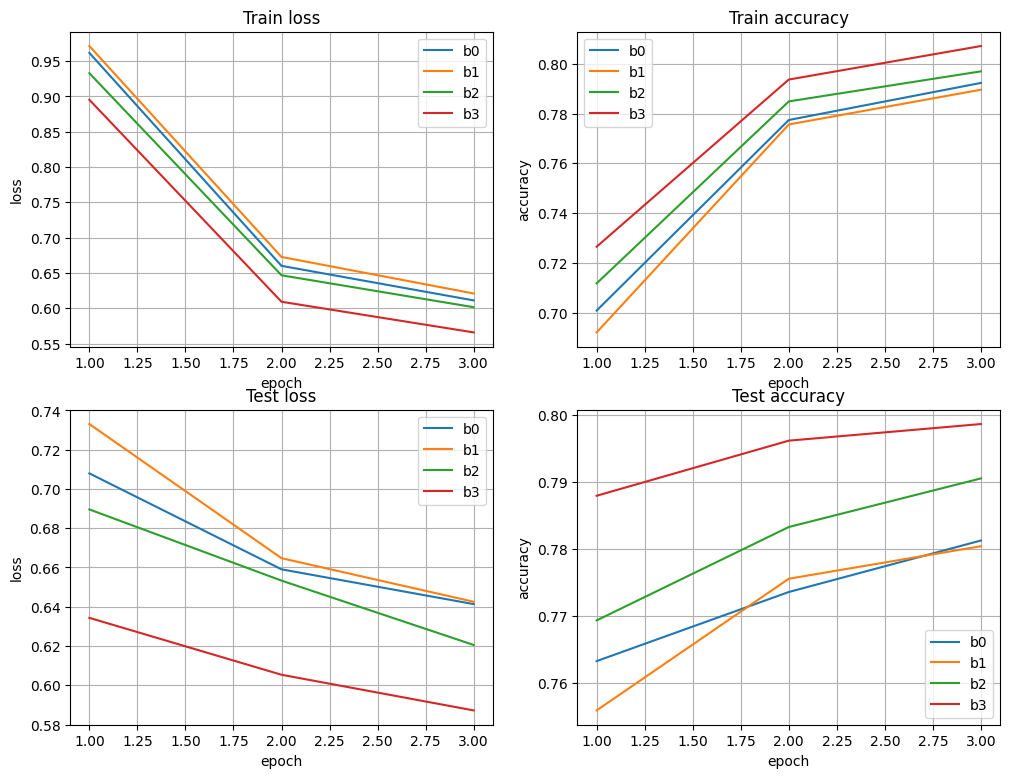

In [ ]:
# <----- your code here ----->
fig = plt.figure(figsize=(12, 9))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

for mt in models:
    ax1.plot(np.arange(1, epochs+1), train_loss_comp[mt], label=f'{mt}')
    ax2.plot(np.arange(1, epochs+1), train_acc_comp[mt], label=f'{mt}')
    ax3.plot(np.arange(1, epochs+1), val_loss_comp[mt], label=f'{mt}')
    ax4.plot(np.arange(1, epochs+1), val_acc_comp[mt], label=f'{mt}')

ax1.set_title('Train loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid()

ax2.set_title('Train accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
ax2.grid()

ax3.set_title('Test loss')
ax3.set_xlabel('epoch')
ax3.set_ylabel('loss')
ax3.legend()
ax3.grid()

ax4.set_title('Test accuracy')
ax4.set_xlabel('epoch')
ax4.set_ylabel('accuracy')
ax4.legend()
ax4.grid()

plt.show()
# <----- your code here ----->


In [32]:
val_acc_comp

{'b0': [0.7488223820924759, 0.7649643838405609, 0.7749253213405609],
 'b1': [0.7499482989311218, 0.7708869487047195, 0.7793543189764023],
 'b2': [0.7618968278169632, 0.7788775265216827, 0.7867532163858414],
 'b3': [0.7714786320924759, 0.7862649351358414, 0.7994198083877564]}

In [34]:
val_acc_comp['b3'][-1]-val_acc_comp['b0'][-1]

0.02449448704719548

Compare results. How does the size and depth of the network affect learning?

<details>
  <summary>When you're ready, click here to see the answer.</summary>
    <li>We see that larger models generally achieve better quality. This is because larger architectures learn better features regarding image classification. Since ImageNet and CIFAR-10 tasks are very similar, as features improve from an ImageNet point of view, they become more useful for CIFAR as well.</li>
    <li>At the same time, the learning rate (the characteristic number of epochs required to reach a plateau) does not generally depend on the architecture. This is because we are not training a huge architecture that would require a number of epochs depending on its size. We only learn one linear layer in each case, so it needs roughly the same number of examples regardless of the model body in front of it.
</details>


# Bonus Task #4: Deep Double Descent [4 points]

*Despite the fact that this task is a bonus, it is highly recommended to try to master it. It is not as scary as it seems from the outside, but it will help to consolidate the acquired skills.*

In this task, you are invited to get acquainted with the effect called [deep double descent](https://arxiv.org/abs/1912.02292). An introductory short version can be found [here](https://openai.com/blog/deep-double-descent/) or [from author's video](https://youtu.be/13CZPWmke6A?t=2164).


## 4.1 Network width impact

You will explore the ability of a neural network to generalize data depending on its architecture. To see this relationship more clearly, we need to add some noise to the training data.

### 4.1.1 Adding noise

You need to prepare three different datasets from the **CIFAR10** already available to you:

     1. In the first one, all class labels are correct
     2. In the second, 10% of class labels are random
     3. In the third, 20% of class labels are random

### 4.1.2 Choose basic model

We will use **ResNet18** as the base model.

You only need to change the number of channels in each convolutional layer (and, accordingly, the dimensions of the linear layer in the classifier). In the graph at OpenAI blogpost, the abscissa shows the "width" of the network, that is, the number of convolution channels included in the network. The depth of the network, i.e. the number of blocks or input layers, must remain _unchanged_.

Start with small convolutions of 4 neurons on the first layer **ResNet18** and gradually increase the number to 128-256 on the first layer. The number of neurons in subsequent layers should change in proportion to the first layer. Use a reasonable step when increasing the number of neurons for plotting.

Your task is to accurately track at what number of parameters the network:

     a) The number of parameters is too small, the network does not have generalizing ability
     b) The number of parameters is optimal or close to optimal (the first local minimum on the graph)
     c) The number of parameters is more than necessary (with an increase in the number of parameters, the values of the loss function after training should tend to the second minimum)

### 4.1.3 Compare models

The purpose of the assignment is to independently obtain the same schedule as that of the authors of the article. However, in our case, we want to draw three different lines on the chart: each line must correspond to a network trained on its own version of the dataset from paragraph **4.1.1**.

In [ ]:
class ResizableResNet18(nn.Module):
     """
     The architecture completely repeats ResNet18, but the ability is added network width changes.
     The first_layer_width parameter sets the width of the first layer,
     all other widths change proportionally
     """
     def __init__(self, in_channels=3, n_classes=10, first_layer_width=64):
         '''
         The class must have the following fields declared:
             *self.conv1
             *self.bn1
             *self.activation
             *self.maxpool
             *self.layers
             *self.avgpool
             *self.flatten
             *self.fc

         A different grouping of parameters is allowed that does not violate the meaning of the network architecture.
         '''

         super().__init__()
         w = first_layer_width
         self.first_layer_width = first_layer_width

         # <----- your code here ----->

     def forward(self, x):

         # <----- your code here ----->

         return x


First, let's make a custom class that adds the required amount of noise to the data.

In [ ]:
# <----- your code here ----->
from torch.utils.data import Dataset

class NoisyDataset(Dataset):
    def __init__(self, clean_dataset=None, noise_level=0, *args, **kwargs):
        super(NoisyDataset).__init__(*args, **kwargs)
        self.clean_dataset = clean_dataset
        self.p = noise_level
        self.mask = np.random.choice([0, 1], p=[1-self.p, self.p], size=len(clean_dataset))
        self.noise_targets = np.random.choice(np.arange(10), size=len(clean_dataset))

    def __len__(self):
        return len(self.clean_dataset)

    def __getitem__(self, idx):
        if self.mask[idx] == 0:
            return self.clean_dataset[idx]
        else:
            return (self.clean_dataset[idx][0], self.noise_targets[idx])
# <----- your code here ----->


Let's create the appropriate dataloaders (note that all labels in the test data are clear).

In [ ]:
# <----- your code here ----->
# train_dataloader and test_dataloader are 'clean' versions

train_data_noisy_10 = NoisyDataset(clean_dataset=train_data, noise_level=0.1)

train_data_noisy_20 = NoisyDataset(clean_dataset=train_data, noise_level=0.2)

train_dataloader_noisy_10 = torch.utils.data.DataLoader(
    train_data_noisy_10, shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)

test_dataloader_noisy_10 = torch.utils.data.DataLoader(
    test_data, shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)

train_dataloader_noisy_20 = torch.utils.data.DataLoader(
    train_data_noisy_20, shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)

test_dataloader_noisy_20 = torch.utils.data.DataLoader(
    test_data, shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)
# <----- your code here ----->


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's put together our datasets, logs for the quality of models and a list of model widths.

**IMPORTANT**:

In the original article, the authors train each model for 4000 epochs. In order to build a high-quality graph, each curve on it must include at least about 20 points. We need to get 3 curves (for different noise levels). In total, we get 4000 x 20 x 3 = 240,000 epochs.

Initially, one ResNet18 training epoch took about 10-30 seconds, depending on the size. By selecting num_workers and batch_size, this time was brought to 5-10 seconds. This gives a total bottom estimate for a running time of 240,000 x 5 = 1.2 x 10**6 seconds = 333 hours.

In this regard, we will have to put up with somewhat rougher results than those of the authors.

In order to have time to build at least something, we resorted to the "heavy artillery" of coarsening, namely:

 * A very small number of different sizes (only 7 values). In order for them to somehow catch the desired behavior of the curves, we distributed these values so that the ranges of interest to us are covered relatively densely, and points are rarely located on long and boring plateaus.
 * Lack of data augmentation, which was done in the article (judging by the results of the authors, its absence had almost no effect on the phenomenon under study).
 * Finally, what we will burn in ML hell for: instead of 4000 epochs with lr = 1e-4, as the authors suggest, we take 10 steps with lr = 1e-3. The hope here is that lr = 1e-3 (which is default value in `torch.optim.Adam`) is small enough so that the model does not go into overdrive and learns normally, and the "amount of training" invested in the models in these two modes is close to the first approximation: roughly speaking, instead of 10 small steps we take 1 step 10 times larger, so the total distance traveled in the linear approximation should be not much less.

We have implemented a variable width ResNet18 here above.

In [ ]:
# <----- your code here ----->
noise_levels = ['0', '10', '20']
datasets = {
    '0' : (train_dataloader, test_dataloader),
    '10': (train_dataloader_noisy_10, test_dataloader_noisy_10),
    '20': (train_dataloader_noisy_20, test_dataloader_noisy_20)
}

widths = [4, 6, 8, 10, 12, 20, 40]
batch_size = 1024

train_loss_big = {}
train_acc_big = {}
val_loss_big = {}
val_acc_big = {}
# <----- your code here ----->


In [ ]:
# <----- your code here ----->
for noise_level in ['0', '10', '20']:
    train_dl, test_dl = datasets[noise_level]

    train_loss_big[noise_level] = {}
    train_acc_big[noise_level] = {}
    val_loss_big[noise_level] = {}
    val_acc_big[noise_level] = {}

    for width in widths:
        train_loss_big[noise_level][width] = []
        train_acc_big[noise_level][width] = []
        val_loss_big[noise_level][width] = []
        val_acc_big[noise_level][width] = []

        model = ResizableResNet18(first_layer_width=width).to(device)

        loss_fn = torch.nn.functional.cross_entropy
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        epochs = 10 #400

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}, noise level {noise_level}, width {width} \n-------------------------------")
            train_loop(model,
                       train_dl,
                       loss_fn,
                       optimizer,
                       history_loss = train_loss_big[noise_level][width],
                       history_acc = train_acc_big[noise_level][width])
            clear_output()
            if (epoch+1) % (epochs//5) == 0:
                test_loop(model,
                           test_dl,
                           loss_fn,
                           history_loss = val_loss_big[noise_level][width],
                           history_acc = val_acc_big[noise_level][width])
# <----- your code here ----->

Batch #:   0%|          | 0/20 [00:00<?, ?it/s]

Validation accuracy: 0.0%, Validation loss: 0.955287 



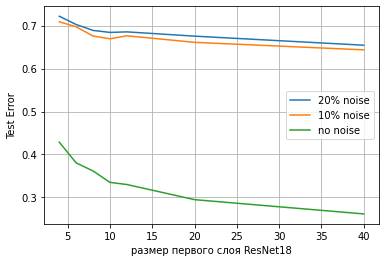

In [ ]:
# <----- your code here ----->
plt.figure()
plt.plot(widths, [1 - val_acc_big['20'][w][-1] for w in widths], label='20% noise')
plt.plot(widths, [1 - val_acc_big['10'][w][-1] for w in widths], label='10% noise')
plt.plot(widths, [1 - val_acc_big['0'][w][-1] for w in widths], label='no noise')
plt.legend(loc='best')
plt.xlabel('The width of first layer ResNet18')
plt.ylabel('Test Error')
plt.grid()
plt.show()
# <----- your code here ----->


Frankly, the results are... not impressive. For comparison, here is the graph that "should" have turned out:

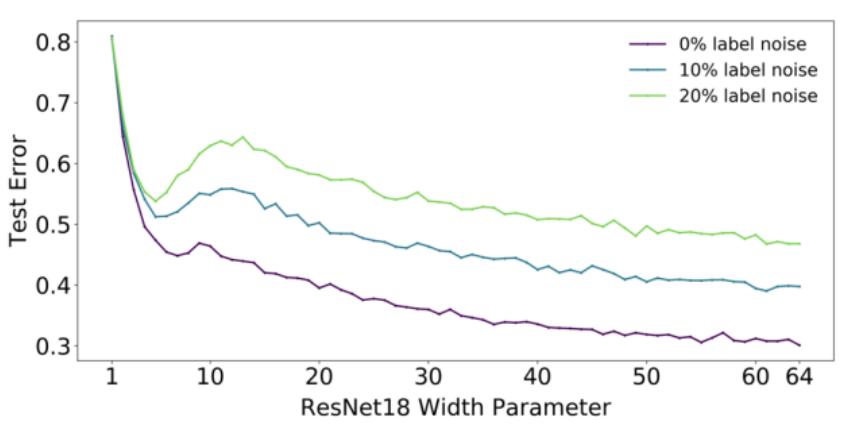

Our local maximum turned out to be very weakly expressed due to an attempt to make the training time more than 10 times less, increasing the speed (learning_rate) instead.

However, you can see that in the region of `first_layer_width` = 10-12 there is indeed a certain peak, a local maximum of the error. Thus, based on these data, we can conclude that with a width of less than 10, the network is not large enough and does not have a learning ability. At a width of about 10, the first local minimum is reached. Further, at a width of 12 or slightly more (unfortunately, the next point on the graph is already a width of 20, so we cannot accurately determine the coordinate of the peak), a local maximum is reached, and then, at large widths, there is a stable tendency to the next minimum.

## 4.2 Network samples impact

This task is similar to the previous one: however, in this case, you will investigate the dependence of the effect not on the width of the network, but on the size of the training sample.

### 4.2.1 Truncate dataset

You need to prepare two different datasets from the **CIFAR10** already available to you:

     1. Full dataset without changes.
     2. 40% of the dataset.
    
### 4.2.2 Compare models

Similarly to **4.1**, the depth and topology of the network must remain unchanged; you are again only required to change the number of neurons in the convolutions. The step and parameter grid can be used the same as in paragraph **4.1**.

For each value of the "width" of the network, it is required to mark two points: the value of the **loss**-function when training on a full dataset and on a partial one.

Just like in the previous task, you can rely on the result of the authors of the article (an example is located above).

In [ ]:
# <----- your code here ----->
from torch.utils.data import Dataset

class TruncatedDataset(Dataset):
    def __init__(self, clean_dataset=None, trunc_level=1, *args, **kwargs):
        super(NoisyDataset).__init__(*args, **kwargs)
        self.clean_dataset = clean_dataset
        self.k = trunc_level

    def __len__(self):
        return int(len(self.clean_dataset) * self.k)

    def __getitem__(self, idx):
            return self.clean_dataset[idx]
# <----- your code here ----->

In [ ]:
# <----- your code here ----->
train_data_short = TruncatedDataset(clean_dataset=train_data, trunc_level=0.4)

train_dataloader_short = torch.utils.data.DataLoader(
    train_data_short, shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)

test_dataloader_short = torch.utils.data.DataLoader(
    test_data, shuffle=True,
    batch_size=batch_size, num_workers=num_workers
)
# <----- your code here ----->


Note that we have already trained the model on the full dataset — this is a "clean" version from the previous task (fortunately, we use the same optimizer and the same number of epochs). Therefore, it remains only to train the model on a stripped-down version of the dataset:

In [ ]:
train_loss_short = {}
train_acc_short = {}
val_loss_short = {}
val_acc_short = {}

widths = np.arange(4, 41, step=12)

for width in widths:
    train_loss_short[width] = []
    train_acc_short[width] = []
    val_loss_short[width] = []
    val_acc_short[width] = []

    model = ResizableResNet18(first_layer_width=width).to(device)

    loss_fn = torch.nn.functional.cross_entropy
    optimizer = torch.optim.Adam(model.parameters())
    epochs = 10 #400

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}, width {width} \n-------------------------------")
        train_loop(model,
                   train_dataloader_short,
                   loss_fn,
                   optimizer,
                   history_loss = train_loss_short[width],
                   history_acc = train_acc_short[width])
        clear_output()
    test_loop(model,
               test_dataloader_short,
               loss_fn,
               history_loss = val_loss_short[width],
               history_acc = val_acc_short[width])

Batch #:   0%|          | 0/10 [00:00<?, ?it/s]

Validation accuracy: 0.0%, Validation loss: 1.268151 



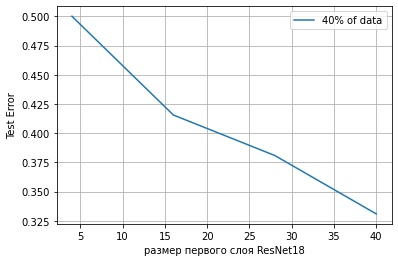

In [ ]:
# widths_full = [4, 6, 8, 10, 12, 20, 40]
widths_short = widths = np.arange(4, 41, step=12)

plt.figure()
# plt.plot(widths_full, [1 - val_acc_big['0'][w][-1] for w in widths_full], label='full data')
plt.plot(widths_short, [1 - val_acc_short[w][-1] for w in widths_short], label='40% of data')
plt.xlabel('The width of first layer ResNet18')
plt.ylabel('Test Error')
plt.grid()
plt.legend()
plt.show()

We see that this is not very similar to the graph obtained by the authors of the article. In this case, an exact match was not expected, since we use ResNet18, and the authors use a transformer. However, there is not even a general similarity here: we completely lack a local maximum with a period of growth before it, and in general the graph turned out to be as "boring" as possible — with an increase in the size of the model, the quality improves, and it is always better to study on a large dataset than on a small one. Probably, again, the problem is the lack of training epochs.

4. **(4 points)**. Upload the implementation of the `ResizableResNet18` (and also written `ResidualBlock`, `ResNetLayer`) class to the Yandex Contest.